# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/pednet_design/code


In [2]:
from mobilkit.umni import *
from setup import P, City, Pednet

In [3]:
import haversine as hs
from igraph import Graph
import osmnx
from shapely.geometry import LineString
import yaml

In [4]:
aus = City('Austin, TX')
cam = City('Cambridge, MA')
tor = City('City of Toronto, Ontario', 'Toronto')

---
# Prepare geometry

## Buildings (OSM)

In [5]:
def save_osm_buildings(city, timeout=480, overwrite=False):
    outfile = city.root / 'osm_buildings.parquet'
    if outfile.exists() and not overwrite:
        return
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        b4_timeout = osmnx.settings.timeout
        osmnx.settings.timeout = timeout
        bld = osmnx.geometries_from_place(city.geocode, tags={'building': True})
        bld['geometry'] = bld.geometry.to_crs(CRS_M).centroid.to_crs(CRS_DEG)
        osmnx.settings.timeout = b4_timeout
    df = (bld.reset_index().rename(columns={'building': 'kind'})
          [['osmid', 'element_type', 'kind', 'geometry']]
          .rename_axis('id').to_crs(CRS_DEG))
    city.save('osm_buildings', df)

**AUSTIN**

In [6]:
save_osm_buildings(aus) # t=2:25

**CAMBRIDGE**

In [7]:
save_osm_buildings(cam) # t=0:03

**TORONTO**

In [8]:
save_osm_buildings(tor) # t=5:09

## OSM POIs

In [9]:
poi_tags = ('amenity', 'healthcare', 'leisure', 'office', 'shop')

In [10]:
def save_osm_pois(city, tags=poi_tags, overwrite=False):
    outfile = city.root / 'osm_pois.parquet'
    if outfile.exists() and not overwrite:
        return
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        poi = osmnx.geometries_from_place(
            city.geocode, tags={x: True for x in tags})
    geom = (poi.to_crs(CRS_M).centroid.to_crs(CRS_DEG)
            .rename('geometry').reset_index())
    poi = geom.merge(pd.concat([
        poi[x].dropna().rename('subcategory').reset_index().assign(category=x)
        for x in tags]), on=('element_type', 'osmid')).rename_axis('id')
    city.save('osm_pois', poi)

**AUSTIN**

In [11]:
save_osm_pois(aus) # t=0:08

**CAMBRIDGE**

In [12]:
save_osm_pois(cam) # t=0:01

**TORONTO**

In [13]:
save_osm_pois(tor) # t=1:03

## SafeGraph POIs

In [14]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/30 01:43:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/30 01:43:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/30 01:43:38 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/04/30 01:43:38 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/04/30 01:43:38 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [15]:
poi_files = (glob(f'{SAFEGRAPH}/us/poi_211104/*.gz') +
             glob(f'{SAFEGRAPH}/ca/poi_211104/*.gz'))

In [16]:
def get_sg_pois(city, poi_files, sp=SP, imp_pois=None, 
                save=True, overwrite=False):
    outfile = city.root / 'sg_pois.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    schema = mk.spark.schema(mk.geo.SG_POIS_SCHEMA)
    pois = sp.read_csv(poi_files, schema=schema, header=True)
    minx, miny, maxx, maxy = city.load('boundary').geometry.bounds.iloc[0]
    pois = (pois.filter(f'{miny} <= latitude and latitude <= {maxy}')
            .filter(f'{minx} <= longitude and longitude <= {maxx}'))
    if imp_pois:
        imp_pois = sp.session.createDataFrame(imp_pois).withColumn(
            'naics_code', F.col('naics_code').cast(T.int32))
        pois = (pois.join(imp_pois, on='naics_code')
                .select('placekey', 'latitude', 'longitude', 'poi_class'))
    else:
        pois = pois.select('placekey', 'latitude', 'longitude', 
                           'naics_code', 'top_category')
    pois = mk.geo.pdf2gdf(pois.toPandas(), 'longitude', 'latitude', CRS_DEG)
    pois = gpd.sjoin(pois, city.boundary.to_crs(CRS_DEG)
                     [['geometry']]).drop(columns='index_right')
    if save:
        city.save('sg_pois', pois)
    return pois

**AUSTIN**

In [17]:
_ = get_sg_pois(aus, poi_files) # t=0:19

**CAMBRIDGE**

In [18]:
_ = get_sg_pois(cam, poi_files) # t=0:06

**TORONTO**

In [19]:
_ = get_sg_pois(tor, poi_files) # t=0:18

## Land use
Categories stored in `{P.data}/_etc/land_use_codes.yaml`.

In [20]:
with open(P.data / '_etc/land_use_codes.yaml', 'rb') as f:
    lu_codes = yaml.safe_load(f)

[**AUSTIN**](https://data.austintexas.gov/Locations-and-Maps/Land-Use-Inventory-Detailed/fj9m-h5qy)

In [21]:
# # t=0:45
# df = (gpd.read_file(aus.root / 'raw/landuse.zip')
#       .rename(columns={'land_use': 'lu_code'})
#       .dropna(subset=['lu_code']).astype({'lu_code': int})
#       .merge(Pdf(lu_codes['Austin']['data'], 
#                  columns=lu_codes['Austin']['columns']), on='lu_code')
#       [['lu_code', 'category', 'dmd_kind', 'geometry']]
#       .rename_axis('id').to_crs(CRS_DEG))
# aus.save('landuse', df)

[**CAMBRIDGE**](https://www.cambridgema.gov/GIS/gisdatadictionary/CDD/CDD_LandUse)

In [22]:
# df = (gpd.read_file(cam.root / 'raw/landuse.zip')
#       .rename(columns=str.lower)[['category', 'geometry']]
#       .merge(Pdf(lu_codes['Cambridge']['data'], 
#                  columns=lu_codes['Cambridge']['columns']), on='category')
#       .rename_axis('id').to_crs(CRS_DEG))
# cam.save('landuse', df)

[**TORONTO**](https://borealisdata.ca/dataset.xhtml?persistentId=doi:10.5683/SP3/1VMJAG)

Downloaded the huge parcel land-use database from https://borealisdata.ca/dataset.xhtml?persistentId=doi:10.5683/SP3/1VMJAG, extracted the zipped file and copied the shapefile `./TorontoLanduse/Landuse/data/Vector/Derived/LandUseByParcel2019_2021v0120211221.shp` to UMNI5.

In [23]:
# # t=1:03
# df = (gpd.read_file(tor.root / 'raw/landuse.gpkg')
#       .rename(columns={'Class_name': 'category'})
#       .merge(Pdf(lu_codes['Toronto']['data'], 
#                  columns=lu_codes['Toronto']['columns']), on='category')
#       [['category', 'dmd_kind', 'geometry']]
#       .rename_axis('id').to_crs(CRS_DEG))
# tor.save('landuse', df)

## Population

In [24]:
def get_us_counties(save=True, overwrite=False):
    outfile = P.data / '_etc/us_counties.shp.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    zipfile = P.root / 'regions/_etc/us_counties.shp.zip'
    df = mk.geo.get_tiger_shp('county', U.mkfile(zipfile))
    df = df.rename(columns=str.lower).to_crs(CRS_DEG)
    df = df[['statefp', 'countyfp', 'geoid', 'name', 
             'aland', 'awater', 'geometry']]
    if save:
        df.to_parquet(U.mkfile(outfile))
        zipfile.unlink()
    return df
    
us_counties = get_us_counties().set_crs(CRS_DEG).disp() # t=0:14

3,234 rows x 7 cols; Memory: 0.8 MiB; CRS: EPSG:4326


,statefp,countyfp,geoid,name,aland,awater,geometry
,<object>,<object>,<object>,<object>,<int64>,<int64>,<geometry>
0,31,039,31039,Cuming,1477645345,10690204,"POLYGON ((-96.555155 41.915868, -96.555153 41...."


In [25]:
def get_acs(city, counties=us_counties, fields=mk.acs.IMP_FIELDS,
            save=True, overwrite=False):
    outfile = city.root / 'acs.parquet'
    if outfile.exists() and not overwrite:
        return city.load('acs')
    city_limit = city.load('boundary')[['geometry']]
    df = city_limit.sjoin(counties)
    statefp = df['statefp'].iloc[0]
    countyfp = ','.join(df['countyfp'])
    geo = [('state', statefp), ('county', countyfp), ('block group', '*')]
    df = mk.acs.download(geo, list(fields.keys())).rename(columns=fields)
    x = Pdf([dict(zip(df.index.names, x)) for x in df.index])
    df.index = x['state'] + x['county'] + x['tract'] + x['block group']
    df = df.rename_axis('geoid')
    zipfile = city.root / 'state_cbgs.shp.zip'
    bgs = mk.geo.get_tiger_shp('bg', zipfile, fips=int(statefp))
    bgs = bgs.rename(columns=str.lower)[['geoid', 'geometry']]
    df = bgs.merge(df, on='geoid')
    zipfile.unlink()
    if save:
        city.save('acs', df)
    return df

# %time x = get_acs(cam); x

**AUSTIN**

In [26]:
_ = get_acs(aus) # t=0:15

**CAMBRIDGE**

In [27]:
_ = get_acs(cam) # t=0:05

**TORONTO**

Could not find population by 158 neighborhood but found population estimate for 2021 in the neighborhood crime data layer obtained from https://open.toronto.ca/dataset/neighbourhood-crime-rates/

In [28]:
df = (gpd.read_file(tor.root / 'raw/crime_rate.geojson')
      .rename(columns={'HoodName':'name', 'F2021_Population_Projection':'popu'})
      [['name','popu','geometry']].rename_axis('geoid').to_crs(CRS_DEG))
tor.save('acs', df)

### Visualize

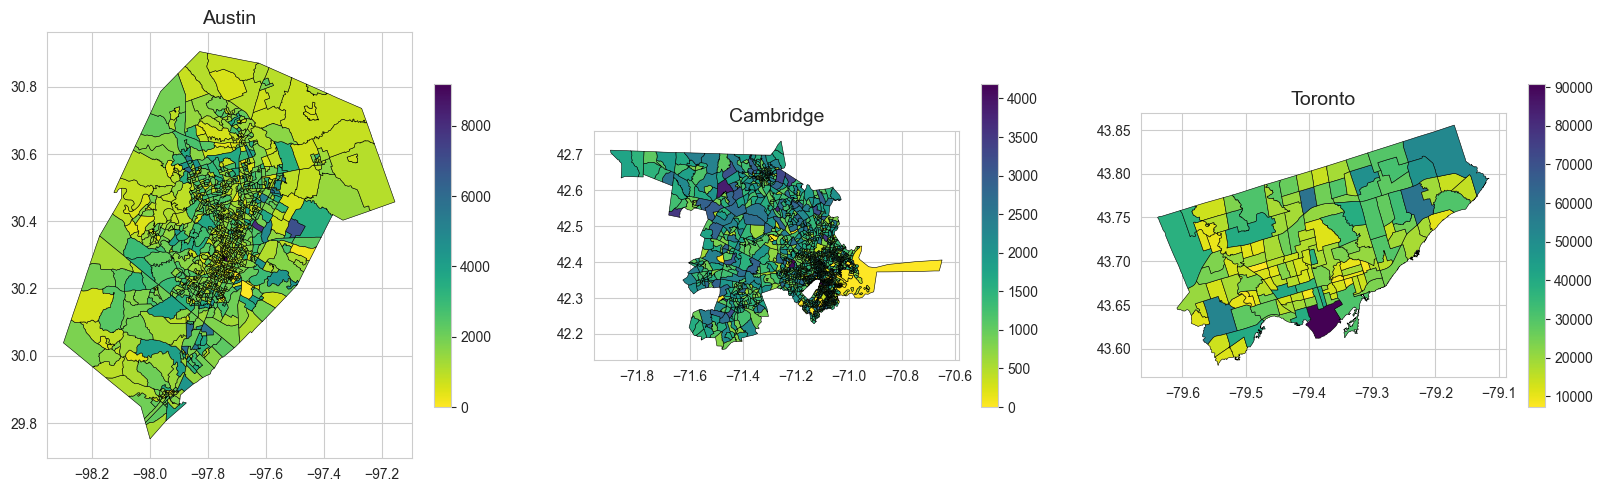

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=100)
for ax, city in zip(ax, [aus, cam, tor]):
    city.load('acs').astype({'popu': int})\
    .plot(ax=ax, column='popu', legend=True, cmap='viridis_r',
          legend_kwds=dict(shrink=0.7), linewidth=0.4, edgecolor='k')
    # ax.grid(False)
    ax.set_title(city.name)
P.imsave('Population by CBG of the study cities')

## OD points
- Classify builgins as origin or destination type (or both)
- Assign buildings population assuming uniform population distribution among all origin (residential) buildings within each block group
- Combine OSM and SafeGraph POIs as destinations to the mix to create the set of OD points

In [30]:
def get_od_points(city, max_people_per_bld=500, save=True, overwrite=False):
    outfile = city.root / 'od_points.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    # load buildings and SafeGraph and OSM POIs
    sg_pois = city.load('sg_pois').rename(
        columns={'placekey': 'base_id', 'top_category': 'category'})
    osm_pois = city.load('osm_pois').rename(columns={'osmid': 'base_id'})
    bld = city.load('osm_buildings').rename(columns={'osmid': 'base_id'})
    # assign land use to buildings
    lu = city.load('landuse')
    bld = bld.sjoin(lu, predicate='within').drop(columns='index_right')
    bld['origin'] = bld['dmd_kind'] == 'O'
    # add enclosing CBG's population info to buildings
    popu = (city.load('acs').reset_index()[['geoid', 'popu', 'geometry']]
            .astype({'popu': float}).query('popu > 0').astype({'popu': int})
            .rename(columns={'popu': 'popu_cbg'}).to_crs(CRS_DEG))
    bld = bld.sjoin(popu.reset_index(), predicate='within')
    # divide the CBG population uniformly to all origin buildings
    popu_per_bld = (bld.query('origin').groupby('geoid')
                    ['popu_cbg'].agg(['count','first'])
                    .assign(weight = lambda df: df['first']/df['count'])
                    ['weight'].clip(0, max_people_per_bld))
    bld = bld.merge(popu_per_bld, on='geoid')
    # combine buildings and POIs to form OD points
    odpt = pd.concat([
        bld[['origin', 'base_id', 'category', 'weight', 'geometry']]
        .assign(source='building'),
        sg_pois[['base_id', 'category', 'geometry']]
        .assign(source='safegraph', origin=False),
        osm_pois[['base_id', 'category', 'geometry']]
        .assign(source='osm', origin=False)
    ]).reset_index(drop=True).rename_axis('id').astype({'base_id': str})
    odpt['category'] = odpt['category'].str.upper()
    odpt.loc[~odpt['origin'], 'weight'] = 0
    odpt['lon'], odpt['lat'] = zip(*[x.coords[0] for x in odpt.geometry])
    if save:
        city.save('od_points', odpt)
    return odpt

# x = get_od_points(cam); x

**AUSTIN**

In [31]:
_ = get_od_points(aus) # t=0:13

**CAMBRIDGE**

In [32]:
_ = get_od_points(cam)

**TORONTO**

In [33]:
_ = get_od_points(tor) # t=0:23

## Closest pednet nodes to OD points
Closest node is not the one obtained from direct nearest point detection between nodes & buildings. Rather, it is the node which is closer of the two end points of the building's closest edge. Also, the distance between this node (edge endpoint) and the closest point on the walkway along the walkway is also computed.

In [34]:
def get_odpt2node(city, spacing=5, save=True, overwrite=False):
    outfile = city.root / 'odpt2node.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    edges = city.load('full_pednet_edges').reset_index().to_crs(CRS_M)
    odpt = city.load('od_points').rename_axis('odpt_id').reset_index().to_crs(CRS_M)
    (odpt_ids, eids), dists = edges.sindex.nearest(
        odpt.geometry, return_all=False, return_distance=True)
    odpt_ids = odpt.iloc[odpt_ids]['odpt_id'].values
    odpt2edge = Pdf({'odpt_id': odpt_ids, 'eid': eids, 'dist_odpt2cp': dists})
    odpt = odpt[['odpt_id', 'geometry']].merge(odpt2edge, on='odpt_id')
    E = (edges.merge(odpt.drop(columns='geometry'), on='eid').drop_duplicates('eid')
         [['eid','geometry','len','src_vid','trg_vid']])
    E['dist'] = E['len'].apply(lambda x: list(np.arange(0, x+1e-4, spacing)) + [x])
    pts = E.explode('dist').reset_index(drop=True)
    pts['geometry'] = [line.interpolate(dist) for line, dist in
                       tqdm(zip(pts.geometry, pts['dist']), total=pts.shape[0])]
    pts = Gdf(pts, crs=CRS_M).rename_axis('pt_id')
    odpt_idx, pts_idx = pts.sindex.nearest(odpt.geometry, return_all=False)
    filt_odpt = (odpt.iloc[odpt_idx].reset_index(drop=True).to_crs(CRS_DEG)
                 .rename(columns={'geometry':'odpt_geom'})
                 [['odpt_id','odpt_geom','dist_odpt2cp']])
    filt_pts = (pts.iloc[pts_idx].reset_index(drop=True).to_crs(CRS_DEG)
                .rename(columns={'dist':'dist_src2cp', 'geometry':'cp_geom'})
                .assign(dist_cp2trg = lambda df: df['len'] - df['dist_src2cp'])
                .query('dist_cp2trg >= 0'))
    odpt = pd.concat([filt_odpt, filt_pts], axis=1).dropna(subset=['odpt_geom','cp_geom'])
    odpt['geometry'] = gpd.GeoSeries([LineString(x) for x in tqdm(
        zip(odpt['odpt_geom'], odpt['cp_geom']), total=odpt.shape[0])], crs=CRS_DEG)
    src = odpt[odpt['dist_src2cp'] <= odpt['len']/2].assign(is_source=True)
    trg = odpt[odpt['dist_src2cp'] > odpt['len']/2].assign(is_source=False)
    src['vid'], src['dist_cp2node'] = src['src_vid'], src['dist_src2cp']
    trg['vid'], trg['dist_cp2node'] = trg['trg_vid'], trg['dist_cp2trg']
    odpt2node = Gdf(pd.concat([src, trg]).astype({'dist_odpt2cp': float, 'dist_cp2node': float})
                    ['odpt_id vid is_source dist_odpt2cp dist_cp2node geometry'.split()]
                    .dropna(subset='geometry').reset_index(drop=True), crs=CRS_DEG)
    if save:
        city.save('odpt2node', odpt2node)
    return odpt2node

# %time x = get_odpt2node(cam); x

**AUSTIN**

In [35]:
_ = get_odpt2node(aus) # t=1:25

**CAMBRIDGE**

In [36]:
_ = get_odpt2node(cam) # t=0:06

**TORONTO**

In [37]:
_ = get_odpt2node(tor) # t=1:52

# Generate OD samples

In [38]:
def sample_odps(city, samp_id, n, max_dist=None, seed=None, save=True):
    outfile = city.root / f'od_samples/{samp_id}.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    odpt = city.load('od_points')
    origs, dests = odpt.query('origin'), odpt.query('~origin')
    pairs = Pdf([], columns=['orig_odpt', 'dest_odpt'])
    np.random.seed(seed)
    pbar = tqdm(total=n)
    last = 0
    while pairs.shape[0] <= n:
        state = None if seed is None else np.random.randint(1, 100000)
        O = origs.sample(n, weights='weight', random_state=state, replace=True)
        D = dests.sample(n, random_state=state, replace=True)
        OD = Pdf({'orig_odpt': O.index, 'dest_odpt': D.index})
        if isinstance(max_dist, float) or isinstance(max_dist, int):
            pts1, pts2 = list(zip(O.lat, O.lon)), list(zip(D.lat, D.lon))
            OD['dist'] = hs.haversine_vector(pts1, pts2, hs.Unit.METERS)
            OD = OD.query(f'dist <= {max_dist}').drop(columns='dist')
        pairs = pd.concat([pairs, OD.reset_index(drop=True)])
        pbar.update(pairs.shape[0] - last)
        last = pairs.shape[0]
    pairs = (pairs.head(n).reset_index(drop=True)
             .rename_axis('od_id').astype(np.int32))
    if save:
        P.params.set({'od_samples': {str(city): {str(samp_id): {
            'num_samples': n, 'max_distance': max_dist,
            'random_seed': seed}}}})
        pairs.to_parquet(outfile)
    return pairs

**AUSTIN**

**CAMBRIDGE**

**TORONTO**

## Simplify sidewalks from generated OD
Combine the sidewalk segments whose endpoints do not have any demand in the generated OD sample

In [39]:
def simplify_sidewalks(city, samp_id, save=True, overwrite=False):
    outfile = city.root / 'simple_sidewalk_pednet_edges.parquet'
    if outfile.exists() and not overwrite:
        return gpd.read_parquet(outfile)
    # load full pednet nodes, edges & graph
    V = city.load('full_pednet_nodes')
    E = city.load('full_pednet_edges')
    G = Graph()
    G.add_vertices(V.shape[0], {'vid': V.index})
    G.add_edges(list(zip(E['src_vid'], E['trg_vid'])), {'eid': E.index} | {
        x: E[x].values for x in E.columns if x != 'geometry'})
    # load OD sample and mapping of OD points to pednet nodes
    od = pd.read_parquet(city.root / f'od_samples/{samp_id}.parquet')
    odpt2V = city.load('odpt2node').set_index('odpt_id')
    # find unique nodes covered in the OD sample
    uV = V.loc[pd.concat([od.merge(odpt2V['vid'], left_on=x, right_index=True)['vid'] 
                          for x in ['orig_odpt','dest_odpt']]).drop_duplicates().values]
    # filter sidewalks whose both endpoints are not junctions and not present in OD sample
    E2 = Pdf([dict(eid=e['eid'], src_vid=e.source, trg_vid=e.target) for e in G.es if all([
        e['exists'],
        not e['is_xwalk'],
        G.vs[e.source].degree() <= 2,
        G.vs[e.target].degree() <= 2,
        G.vs[e.source]['vid'] not in uV.index,
        G.vs[e.target]['vid'] not in uV.index,
    ])]).merge(E[['len','geometry']], on='eid').set_index('eid')
    # cluster nodes subset by the filtered edges
    G2 = G.induced_subgraph(G.vs.select(set(E2['src_vid']) | set(E2['trg_vid'])))
    clusters = Pdf({'cid': G2.clusters().membership}, index=[v['vid'] for v in G2.vs])
    # assign the created cluster IDs to the candidate edges
    E2 = E2.merge(clusters, left_on='src_vid', right_index=True)
    # combine the edges using the above clusters
    E3 = []
    for cid, df in tqdm(E2.groupby('cid')):
        # only include edge clusters which have two endpoints (i.e., two 1-degree nodes)
        vcount = np.array(np.unique(df[['src_vid','trg_vid']], return_counts=True)).T
        deg1V = vcount[vcount[:, 1] == 1][:, 0]
        if deg1V.size == 2:
            E3.append((cid, *deg1V, vcount[:, 0], df.index.values, df['len'].sum(),
                       gpd.GeoSeries(df.geometry).unary_union))
    E3 = Pdf(E3, columns=['cid','src_vid','trg_vid','vids','eid','len','geometry'])
    # remove the non-junction, non-demand nodes that are not endpoints of edge clusters
    E4 = (pd.concat([E.drop(E3['eid'].explode().values).reset_index(),
                     E3.assign(is_xwalk=False, exists=True, orig_id=-1, kind=None)])
          [['eid','orig_id','is_xwalk','exists','src_vid','trg_vid','len','geometry']]
          .reset_index(drop=True).rename_axis())
    if save:
        E4.astype({'eid': str}).to_parquet(outfile)
    return E4

# %time x = simplify_sidewalks(cam, 's1', save=0); x

**AUSTIN**

In [40]:
_ = simplify_sidewalks(aus, 's1') # t=0:55

**CAMBRIDGE**

In [41]:
_ = simplify_sidewalks(cam, 's1')

**TORONTO**

In [42]:
_ = simplify_sidewalks(tor, 's1') # t=0:03